In [1]:
from matplotlib import pyplot as plt
import numpy as np
import rootpy as rt
import root_numpy as rnp
from rootpy.io import root_open
from scipy.optimize import curve_fit
from peakdetect import peakdet

/home/noah/Programs/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.0 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
data_path = "../data/take103_normalized_waveforms.root"

data_tree = root_open(data_path, 'read').take103_normalized_waveforms

neutron_times, neutron_waveforms  = list(), list()
photon_times, photon_waveforms   = list(), list()

def find_50_pct_rising_edge(waveform):
    index_waveform_max = np.max(np.where(waveform == np.max(waveform))[0])
    tmp_waveform = waveform[:index_waveform_max+1]

    diff = np.absolute(tmp_waveform - 0.5*np.max(waveform))
    
    pct_50_index = np.where(diff == np.min(diff))[0][0]
        
    return pct_50_index

for event in data_tree:
    # The index is stored as a string because it comes from a C++ int datatype. 
    # As read in, its of the form "Int(number)", where 'number' is the actual value.
    # Hence, we select only the number portion and convert this to an integer
    tdc = int(event['start_index'][4:-1])
    waveform = np.array(event['normalized_adc_event'])[tdc:]
    
    pct_50_rising_edge = find_50_pct_rising_edge(waveform)
    
    time_array = np.arange(len(waveform), dtype=float)
    time_array -= pct_50_rising_edge
    time_array *= 2
    
#     waveform /= np.max(waveform)
    # Sort the events into those tagged as photon and those as neutrons
    if event['isNeutron']:
        neutron_times.append(time_array)
        neutron_waveforms.append(waveform)
    else:
        photon_times.append(time_array)
        photon_waveforms.append(waveform)

neutron_waveforms = np.array(neutron_waveforms)
photon_waveforms  = np.array(photon_waveforms)     
        
print("Number of neutrons: ", len(neutron_waveforms))        
print("Number of photons: ",  len(photon_waveforms))

Number of neutrons:  1080
Number of photons:  1657


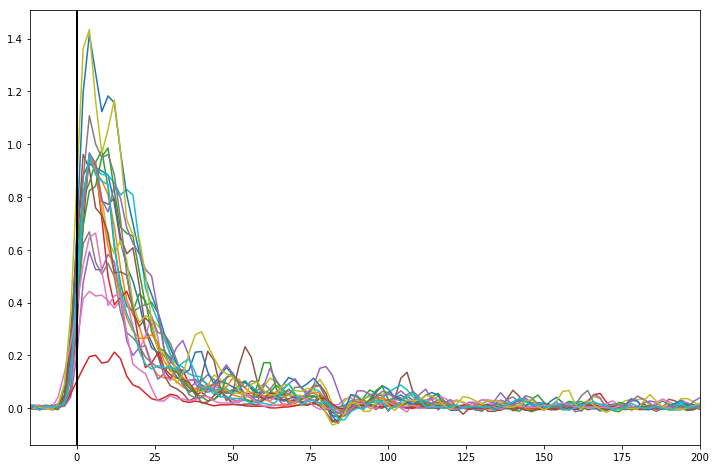

In [3]:
plt.figure(figsize = (12,8))

for i in range(20+0*len(neutron_waveforms)):
    plt.plot(neutron_times[i], neutron_waveforms[i])
    plt.axvline(x=0, color = 'k')
    plt.xlim(-15, 200)
plt.show()

In [4]:
def get_bin_index(bins, value):
    return (np.abs(bins - value)).argmin()

def integrate_waveform(start, end, bins, waveform):
    first_index = get_bin_index(bins, start)
    last_index  = get_bin_index(bins, end)
    
    # Reverse the first and the last index if the order is incorrect
    if first_index > last_index:
        first_index, last_index = last_index, first_index
        
    total = np.sum(waveform[first_index:last_index+1])
    return total

def calculate_qvalue(bins, waveform, tail_start, tail_end):
    # Return zero if the tail region has zero extent, otherwise we'd divide by zero
    if tail_start == tail_end:
        return np.nan
    
    tail_integral = integrate_waveform(tail_start, tail_end, bins, waveform)
    qvalue = tail_integral / total_integral
    return qvalue

# The integration of the whole waveforms
INT_RANGE_START = 0
INT_RANGE_END   = 200

In [5]:
def gaussian(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def gaussian_fit(bin_centers, histogram):
    histogram_max = np.max(histogram)
    histogram_max_index = np.max(np.where(histogram == histogram_max)[0])
    p0 = [histogram_max, bin_centers[histogram_max_index], 0.1]
    
    try:
        params, var_matrix = curve_fit(gaussian, bin_centers, histogram, p0=p0)
        return params
    
    except RuntimeError:
        plt.plot(bin_centers, histogram, color = 'b', ls = '--')
        plt.show()
    
        return [0,0,0]

In [6]:
def get_fwhm(histogram, bin_centers):
    half_max = 0.5 * np.max(histogram)
    
    hist_minus_hm = histogram - half_max
    d = np.sign(hist_minus_hm[1:]) - np.sign(hist_minus_hm[:-1])
        
    left_idx  = np.where(d > 0)[0][0]
    right_idx = np.where(d < 0)[0][0]
#     print(d)
#     print(bin_centers[right_idx], bin_centers[left_idx])
    
    return (bin_centers[right_idx] - bin_centers[left_idx])

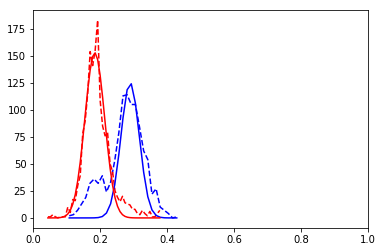

2.6204231793757806


In [7]:
neutron_qvalues = list()
photon_qvalues = list()

tail_start = 27
tail_end   = 170

for i in range(len(neutron_waveforms)):
    total_integral = integrate_waveform(INT_RANGE_START,  INT_RANGE_END, 
                                        neutron_times[i], neutron_waveforms[i])
    
    qvalue = calculate_qvalue(neutron_times[i], neutron_waveforms[i], tail_start, tail_end)
    neutron_qvalues.append(qvalue)
    
for i in range(len(photon_waveforms)):
    total_integral = integrate_waveform(INT_RANGE_START,  INT_RANGE_END, 
                                        photon_times[i], photon_waveforms[i])

    qvalue = calculate_qvalue(photon_times[i], photon_waveforms[i], tail_start, tail_end)
    photon_qvalues.append(qvalue)

neutron_histogram, neutron_bins = np.histogram(neutron_qvalues, bins='auto')
neutron_bin_centers =  0.5*(neutron_bins[1:]+neutron_bins[:-1])

photon_histogram, photon_bins = np.histogram(photon_qvalues, bins='auto')
photon_bin_centers =  0.5*(photon_bins[1:]+photon_bins[:-1])

plt.plot(neutron_bin_centers, neutron_histogram, color = 'b', ls = '--')
plt.plot(photon_bin_centers,  photon_histogram, color = 'r', ls = '--')

neutron_histogram[np.where(neutron_histogram < 0.5*np.max(neutron_histogram))] = 0

neutron_params = gaussian_fit(neutron_bin_centers, neutron_histogram)
photon_params =  gaussian_fit(photon_bin_centers, photon_histogram)

plt.plot(neutron_bin_centers, gaussian(neutron_bin_centers, *neutron_params), color = 'b')
plt.plot(photon_bin_centers,  gaussian(photon_bin_centers, *photon_params), color = 'r')
plt.xlim([0,1])
plt.show()


# neutron_max_location = neutron_bin_centers[np.where(neutron_histogram == np.max(neutron_histogram))[0][0]]
# photon_max_location  = photon_bin_centers[np.where(photon_histogram  == np.max(photon_histogram))[0][0]]

# neutron_fwhm = get_fwhm(neutron_histogram, neutron_bin_centers) 
# print(neutron_fwhm)
# photon_fwhm  = get_fwhm(photon_histogram, photon_bin_centers)

# figure_of_merit = neutron_max_location - photon_max_location
# figure_of_merit /= neutron_fwhm + photon_fwhm

figure_of_merit = neutron_params[1] - photon_params[1]
figure_of_merit /= np.sqrt(neutron_params[2]**2 + photon_params[2]**2)

print(figure_of_merit)


In [8]:
def calculate_figure_of_merit(tail_start, tail_end):    
    neutron_qvalues = list()
    photon_qvalues = list()

    for i in range(len(neutron_waveforms)):
        total_integral = integrate_waveform(INT_RANGE_START,  INT_RANGE_END, 
                                            neutron_times[i], neutron_waveforms[i])

        qvalue = calculate_qvalue(neutron_times[i], neutron_waveforms[i], tail_start, tail_end)
        neutron_qvalues.append(qvalue)

    for i in range(len(photon_waveforms)):
        total_integral = integrate_waveform(INT_RANGE_START,  INT_RANGE_END, 
                                            photon_times[i], photon_waveforms[i])

        qvalue = calculate_qvalue(photon_times[i], photon_waveforms[i], tail_start, tail_end)
        photon_qvalues.append(qvalue)


    neutron_histogram, neutron_bins = np.histogram(neutron_qvalues, bins='auto')
    neutron_bin_centers =  0.5*(neutron_bins[1:]+neutron_bins[:-1])

    photon_histogram, photon_bins = np.histogram(photon_qvalues, bins='auto')
    photon_bin_centers =  0.5*(photon_bins[1:]+photon_bins[:-1])
    
#     neutron_max_location = neutron_bin_centers[np.where(neutron_histogram == np.max(neutron_histogram))[0][0]]
#     photon_max_location  = photon_bin_centers[np.where(photon_histogram  == np.max(photon_histogram))[0][0]]
    
#     neutron_fwhm = get_fwhm(neutron_histogram, neutron_bin_centers) 
#     photon_fwhm  = get_fwhm(photon_histogram, photon_bin_centers)
    
#     figure_of_merit = neutron_max_location - photon_max_location
#     figure_of_merit /= neutron_fwhm + photon_fwhm


    neutron_histogram[np.where(neutron_histogram < 0.5*np.max(neutron_histogram))] = 0

    neutron_params = gaussian_fit(neutron_bin_centers, neutron_histogram)
    photon_params =  gaussian_fit(photon_bin_centers, photon_histogram)

    figure_of_merit = neutron_params[1] - photon_params[1]
    figure_of_merit /= np.sqrt(neutron_params[2]**2 + photon_params[2]**2)

#     print(figure_of_merit)
    
    return figure_of_merit

In [9]:
tail_start_range = [0,55]
tail_end_range   = [105, 175]
tail_start_steps = 60
tail_end_steps   = 60

tail_starts = np.linspace(tail_start_range[0], tail_start_range[1], tail_start_steps)
tail_ends   = np.linspace(tail_end_range[0],   tail_end_range[1],   tail_end_steps)

# start_end_array = np.empty((tail_start_steps, tail_end_steps), object)
figure_of_merit_array  = np.empty(shape = (tail_start_steps, tail_end_steps), dtype = float)
# start_ends  = np.empty(shape = (tail_start_steps, tail_end_steps), dtype = object)

i = 0
print("0%%...")
for i in range(tail_start_steps):
    for j in range(tail_end_steps):
        figure_of_merit_array[i][j] = calculate_figure_of_merit(tail_starts[i], tail_ends[j])
        
        i += 1
        if i%200 == 0:
            print("...%0.3f%%..." %(i / (tail_start_steps * tail_end_steps)))
        
#         start_ends[i][j] = (tail_starts[i], tail_ends[j])

print("Done")

Done


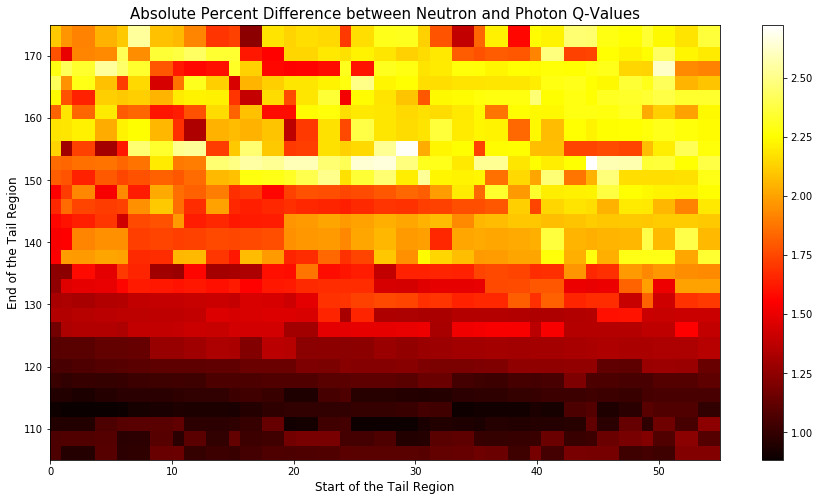

In [10]:
plt.figure(figsize = (15,8))
plt.imshow(figure_of_merit_array, origin = 'lower',
           extent=(tail_start_range[0], tail_start_range[1], 
                   tail_end_range[0],   tail_end_range[1]),
           aspect = 'auto',
           cmap = 'hot')

plt.colorbar()
plt.cm.get_cmap().set_bad(color='red')

plt.title("Absolute Percent Difference between Neutron and Photon Q-Values", fontsize = 15)
plt.xlabel("Start of the Tail Region", fontsize = 12)
plt.ylabel("End of the Tail Region",fontsize = 12)
plt.show()